In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
np.random.seed(42)

In [10]:

n_samples = 1500
n_features = 2
n_classes = 5
X, y = make_blobs(n_samples=n_samples, centers=n_classes, n_features=n_features, random_state=42, cluster_std=1.2)


try:
    enc = OneHotEncoder(sparse_output=False)
except TypeError:
    enc = OneHotEncoder(sparse=False)

y_onehot = enc.fit_transform(y.reshape(-1, 1))


X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.20, random_state=42)

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)


Shapes: (1200, 2) (300, 2) (1200, 5) (300, 5)


In [16]:

class NeuralNetwork:
    def __init__(self, input_size, h1, h2, h3, output_size, lr=0.01, seed=42):
        np.random.seed(seed)
        self.lr = lr


        self.W1 = np.random.randn(input_size, h1) * np.sqrt(2. / input_size)
        self.b1 = np.zeros((1, h1))

        self.W2 = np.random.randn(h1, h2) * np.sqrt(2. / h1)
        self.b2 = np.zeros((1, h2))

        self.W3 = np.random.randn(h2, h3) * np.sqrt(2. / h2)
        self.b3 = np.zeros((1, h3))

        self.W4 = np.random.randn(h3, output_size) * np.sqrt(2. / h3)
        self.b4 = np.zeros((1, output_size))

    def relu(self, x):
        return np.maximum(0, x)

    def softmax(self, z):

        z_shift = z - np.max(z, axis=1, keepdims=True)
        exp = np.exp(z_shift)
        return exp / np.sum(exp, axis=1, keepdims=True)

    def forward(self, X):
        self.z1 = X @ self.W1 + self.b1
        self.a1 = self.relu(self.z1)

        self.z2 = self.a1 @ self.W2 + self.b2
        self.a2 = self.relu(self.z2)

        self.z3 = self.a2 @ self.W3 + self.b3
        self.a3 = self.relu(self.z3)

        self.z4 = self.a3 @ self.W4 + self.b4
        self.output = self.softmax(self.z4)
        return self.output

    def loss(self, y_true, y_pred):

        eps = 1e-9
        return -np.mean(np.sum(y_true * np.log(y_pred + eps), axis=1))

    def backward(self, X, y_true):
        m = X.shape[0]

        d4 = (self.output - y_true) / m

        self.dW4 = self.a3.T @ d4
        self.db4 = np.sum(d4, axis=0, keepdims=True)

        d3 = (d4 @ self.W4.T) * (self.z3 > 0)
        self.dW3 = self.a2.T @ d3
        self.db3 = np.sum(d3, axis=0, keepdims=True)

        d2 = (d3 @ self.W3.T) * (self.z2 > 0)
        self.dW2 = self.a1.T @ d2
        self.db2 = np.sum(d2, axis=0, keepdims=True)

        d1 = (d2 @ self.W2.T) * (self.z1 > 0)
        self.dW1 = X.T @ d1
        self.db1 = np.sum(d1, axis=0, keepdims=True)

        self.W4 -= self.lr * self.dW4
        self.b4 -= self.lr * self.db4

        self.W3 -= self.lr * self.dW3
        self.b3 -= self.lr * self.db3

        self.W2 -= self.lr * self.dW2
        self.b2 -= self.lr * self.db2

        self.W1 -= self.lr * self.dW1
        self.b1 -= self.lr * self.db1

    def train(self, X, y, epochs=2000, verbose_every=200):
        losses = []
        t0 = time.time()
        for i in range(epochs):
            y_pred = self.forward(X)
            l = self.loss(y, y_pred)
            losses.append(l)
            self.backward(X, y)

            if (i % verbose_every) == 0:
                print(f"Epoch {i:5d} | Loss: {l:.6f}")
        t1 = time.time()
        print(f"Training finished in {t1 - t0:.2f}s")
        return losses


In [17]:
input_size = X_train.shape[1]
h1, h2, h3 = 64, 32, 16
output_size = y_train.shape[1]
lr = 0.01
epochs = 3000

model = NeuralNetwork(input_size, h1, h2, h3, output_size, lr=lr, seed=42)
losses = model.train(X_train, y_train, epochs=epochs, verbose_every=300)


Epoch     0 | Loss: 8.357081
Epoch   300 | Loss: 0.116240
Epoch   600 | Loss: 0.113211
Epoch   900 | Loss: 0.111355
Epoch  1200 | Loss: 0.109829
Epoch  1500 | Loss: 0.108456
Epoch  1800 | Loss: 0.107163
Epoch  2100 | Loss: 0.105948
Epoch  2400 | Loss: 0.104794
Epoch  2700 | Loss: 0.103656
Training finished in 14.18s


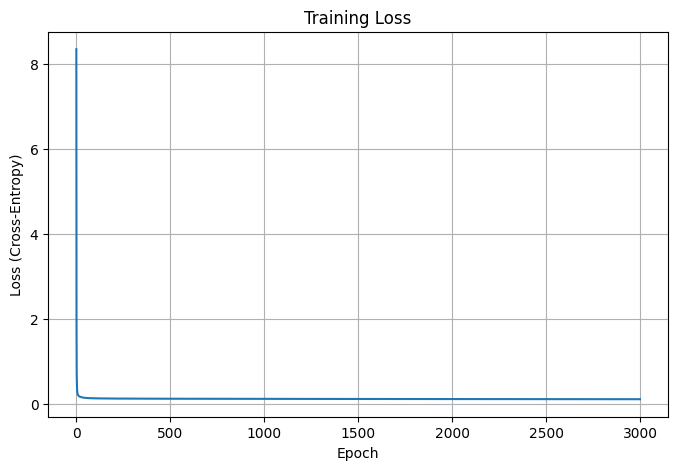

In [13]:
plt.figure(figsize=(8,5))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss (Cross-Entropy)")
plt.title("Training Loss")
plt.grid(True)
plt.show()


In [14]:
y_prob = model.forward(X_test)
y_pred_labels = np.argmax(y_prob, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

acc = accuracy_score(y_true_labels, y_pred_labels)
prec, rec, f1, support = precision_recall_fscore_support(y_true_labels, y_pred_labels, average=None, zero_division=0)

print(f"Test Accuracy: {acc:.4f}\n")
for i in range(output_size):
    print(f"Class {i}: Precision={prec[i]:.4f}  Recall={rec[i]:.4f}  F1={f1[i]:.4f}  Support={support[i]}")
print("\nClassification report:\n")
print(classification_report(y_true_labels, y_pred_labels, digits=4))


Test Accuracy: 0.9600

Class 0: Precision=0.9825  Recall=0.9655  F1=0.9739  Support=58
Class 1: Precision=0.9574  Recall=0.8654  F1=0.9091  Support=52
Class 2: Precision=1.0000  Recall=1.0000  F1=1.0000  Support=70
Class 3: Precision=0.9851  Recall=1.0000  F1=0.9925  Support=66
Class 4: Precision=0.8644  Recall=0.9444  F1=0.9027  Support=54

Classification report:

              precision    recall  f1-score   support

           0     0.9825    0.9655    0.9739        58
           1     0.9574    0.8654    0.9091        52
           2     1.0000    1.0000    1.0000        70
           3     0.9851    1.0000    0.9925        66
           4     0.8644    0.9444    0.9027        54

    accuracy                         0.9600       300
   macro avg     0.9579    0.9551    0.9556       300
weighted avg     0.9615    0.9600    0.9600       300



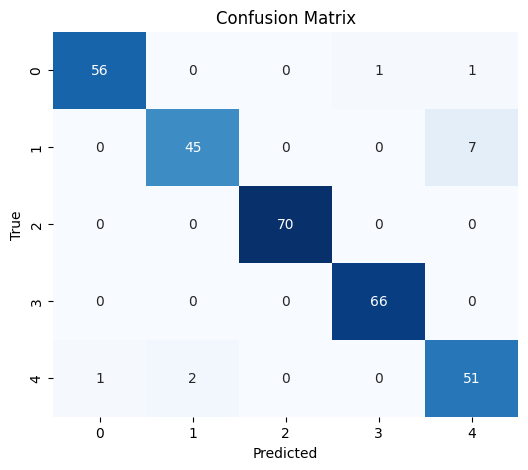

In [15]:
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
